In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
import dlib

In [3]:
import imutils
from imutils import face_utils
from collections import OrderedDict

In [4]:
from cust_face_utils.helpers import FACIAL_LANDMARKS_68_IDXS
from cust_face_utils.helpers import FACIAL_LANDMARKS_5_IDXS
from cust_face_utils.helpers import shape_to_np
from cust_face_utils.facealigner import FaceAligner


In [5]:
from skimage.feature import local_binary_pattern
# import the necessary packages
from skimage import feature

from scipy.stats import itemfreq
from sklearn import decomposition
import tqdm

In [6]:
# plt.rcParams["figure.figsize"] = (4,4)

In [7]:
# face_cascade = cv2.CascadeClassifier('data/haarcascade_frontalface_default.xml')
# eye_cascade = cv2.CascadeClassifier('data/haarcascade_eye.xml')


In [8]:
# glass_cascade= cv2.CascadeClassifier('data/glasses_cascade.xml')

In [9]:
# img = cv2.imread(r'GlassesDetection\example_data_glasses\with_glasses\3.jpg')

In [10]:
# plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [6]:
images_base_path=r"..\GlassesDetection\example_data_glasses"
glasses_path=os.path.join(images_base_path, r"with_glasses")
no_glasses_path=os.path.join(images_base_path, r"without_glasses")

In [7]:
glasses_fname = os.listdir(glasses_path)
no_glasses_fname = os.listdir(no_glasses_path)

In [8]:
# glasses_fname

In [9]:
def load_dlib_detector(path):
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(path)
    return detector, predictor

In [10]:
# def face_detector(image_gray):
#     # запускаем детектор лиц
#     faces = face_cascade.detectMultiScale(image_gray, 1.07, 5)
# #     print(faces)
#     if len(faces)>=1:
#         x,y,w,h = max(faces, key=lambda rect: rect[2] * rect[3])
#         return dlib.rectangle(x,y,x+w,y+h)
#     else:
#         return None

In [11]:
def face_detector_dlib(detector, image_gray):
    # запускаем детектор лиц
    rects = detector(image_gray, 1)
#     print(faces)
    if len(rects) > 0:
        rect = max(rects, key=lambda rect: rect.width() * rect.height())
        return rect
    else:
        return None

In [12]:
# class FaceAligner:
#     def __init__(self, predictor, desiredLeftEye=(0.27, 0.45),
#                  desiredFaceWidth=150, desiredFaceHeight=64):
#         # store the facial landmark predictor, desired output left
#         # eye position, and desired output face width + height
#         self.predictor = predictor
#         self.desiredLeftEye = desiredLeftEye
#         self.desiredFaceWidth = desiredFaceWidth
#         self.desiredFaceHeight = desiredFaceHeight

#         # if the desired face height is None, set it to be the
#         # desired face width (normal behavior)
#         if self.desiredFaceHeight is None:
#             self.desiredFaceHeight = self.desiredFaceWidth

#     def align(self, image, gray, rect):
#         # convert the landmark (x, y)-coordinates to a NumPy array
#         shape = self.predictor(gray, rect)
#         shape = shape_to_np(shape)

#         # simple hack ;)
#         if (len(shape) == 68):
#             # extract the left and right eye (x, y)-coordinates
#             (lStart, lEnd) = FACIAL_LANDMARKS_68_IDXS["left_eye"]
#             (rStart, rEnd) = FACIAL_LANDMARKS_68_IDXS["right_eye"]
#         else:
#             (lStart, lEnd) = FACIAL_LANDMARKS_5_IDXS["left_eye"]
#             (rStart, rEnd) = FACIAL_LANDMARKS_5_IDXS["right_eye"]

#         leftEyePts = shape[lStart:lEnd]
#         rightEyePts = shape[rStart:rEnd]

#         NoseBottom = shape[31:36].mean(axis=0).astype("int")
#         (lStart, lEnd) = FACIAL_LANDMARKS_68_IDXS["left_eyebrow"]
#         left_eyebrow_center =  shape[lStart:lEnd].mean(axis=0).astype("int")
#         (rStart, rEnd) = FACIAL_LANDMARKS_68_IDXS["right_eyebrow"]
#         right_eyebrow_center = shape[rStart:rEnd].mean(axis=0).astype("int")

#         x_left   = shape[0][0]
#         y_top    = min(left_eyebrow_center[1], right_eyebrow_center[1])
#         x_right  = shape[16][0]
#         y_bottom = NoseBottom[1]
        
# #         image_cropped = output[y_top:y_bottom, x_left:x_right]
#         # compute the center of mass for each eye
# #         leftEyePts -= np.array([x_left,y_top])
# #         rightEyePts -= np.array([x_left,y_top])
#         leftEyeCenter = leftEyePts.mean(axis=0).astype("int") 
#         rightEyeCenter = rightEyePts.mean(axis=0).astype("int") 
# #         self.desiredFaceWidth = (x_right - x_left)
# #         self.desiredFaceHeight = (y_bottom - y_top)

#         # compute the angle between the eye centroids
#         dY = rightEyeCenter[1] - leftEyeCenter[1]
#         dX = rightEyeCenter[0] - leftEyeCenter[0]
#         angle = np.degrees(np.arctan2(dY, dX)) - 180

#         # compute the desired right eye x-coordinate based on the
#         # desired x-coordinate of the left eye
#         desiredRightEyeX = 1.0 - self.desiredLeftEye[0]

#         # determine the scale of the new resulting image by taking
#         # the ratio of the distance between eyes in the *current*
#         # image to the ratio of distance between eyes in the
#         # *desired* image
#         dist = np.sqrt((dX ** 2) + (dY ** 2))
#         desiredDist = (desiredRightEyeX - self.desiredLeftEye[0])
#         desiredDist *= self.desiredFaceWidth
#         scale = desiredDist / dist

#         # compute center (x, y)-coordinates (i.e., the median point)
#         # between the two eyes in the input image
#         eyesCenter = ((leftEyeCenter[0] + rightEyeCenter[0]) // 2,
#                       (leftEyeCenter[1] + rightEyeCenter[1]) // 2)

#         # grab the rotation matrix for rotating and scaling the face
#         M = cv2.getRotationMatrix2D(eyesCenter, angle, scale)

#         # update the translation component of the matrix
#         tX = self.desiredFaceWidth * 0.5
#         tY = self.desiredFaceHeight * self.desiredLeftEye[1]
#         M[0, 2] += (tX - eyesCenter[0])
#         M[1, 2] += (tY - eyesCenter[1])

#         # apply the affine transformation
#         (w, h) = (self.desiredFaceWidth, self.desiredFaceHeight)
#         output = cv2.warpAffine(image, M, (w, h),
#                                 flags=cv2.INTER_CUBIC)
# #        
#         # return the aligned face
#         return output


In [13]:
# class LocalBinaryPatterns:
#     def __init__(self, numPoints, radius, method):
#         # store the number of points and radius
#         self.numPoints = numPoints
#         self.radius = radius
#         self.method = method

#     def describe(self, image, gridW = 16, gridH = 16, eps=1e-7):
#         # compute the Local Binary Pattern representation
#         # of the image, and then use the LBP representation
#         # to build the histogram of patterns

# #         lbp = feature.local_binary_pattern(image, self.numPoints,
# #             self.radius, method=self.method)
# #         (hist, _) = np.histogram(lbp.ravel(),
# #                                 bins=np.arange(0, self.numPoints + 3),
# #                                 range=(0, self.numPoints + 2))

# #         # normalize the histogram
# #         hist = hist.astype("float")
# #         hist /= (hist.sum() + eps)

# #         # return the histogram of Local Binary Patterns
# #         return hist        
        
#         lbp = feature.local_binary_pattern(image, self.numPoints,
#             self.radius, method="uniform")

#         n_bins = int(lbp.max() + 1)
# #         print(n_bins)
#         h,w,_ = img.shape

#         # Define the window size
#         windowsize_r = gridH
#         windowsize_c = gridW
#         hist_all = None

#         # Crop out the window and calculate the histogram
#         for r in range(0,w- windowsize_r, windowsize_r):
#             for c in range(0,h - windowsize_c, windowsize_c):
#                 window = lbp[r:r+windowsize_r,c:c+windowsize_c].flatten()
#                 (hist, _) = np.histogram(window,
#                                         bins=n_bins,
#                                         range=(0, n_bins))                
#                 if hist_all is None:
#                     hist_all  = hist
#                 else:
#                     hist_all = np.hstack([hist_all,hist])
#         # normalize the histogram
#         hist_all = hist_all.astype("float")
#         hist_all /= (hist_all.sum() + eps)
#         # return the histogram of Local Binary Patterns
#         return hist_all

In [15]:
def calculateHOG(img_list):
    
    hist_features = None

    cell_size = (8, 8)  # h x w in pixels
    block_size = (8, 8)  # h x w in cells
    nbins = 32  # number of orientation bins

    img = img_list[0]
    # winSize is the size of the image cropped to an multiple of the cell size
    hog = cv2.HOGDescriptor(_winSize=(img.shape[1] // cell_size[1] * cell_size[1],
                                      img.shape[0] // cell_size[0] * cell_size[0]),
                            _blockSize=(block_size[1] * cell_size[1],
                                        block_size[0] * cell_size[0]),
                            _blockStride=(cell_size[1], cell_size[0]),
                            _cellSize=(cell_size[1], cell_size[0]),
                            _nbins=nbins)    
    
    for i in tqdm.tqdm(range(len(img_list))):
        img = img_list[i].astype(np.uint8)
#         n_cells = (img.shape[0] // cell_size[0], img.shape[1] // cell_size[1])
        hog_feats = hog.compute(img)#\
#                        .reshape(n_cells[1] - block_size[1] + 1,
#                                 n_cells[0] - block_size[0] + 1,
#                                 block_size[0], block_size[1], nbins) \
#                        .transpose((1, 0, 2, 3, 4))  # index blocks by rows first
                
        if hist_features is None:
            hist_features = np.expand_dims(hog_feats,axis =0)
        else:
            hist_features = np.vstack((hist_features,  np.expand_dims(hog_feats,axis =0)))
        
    return hist_features

In [28]:
def getPCA_transformer(X, ncomp=2):
    pca = decomposition.PCA(n_components=ncomp)
    X_centered = X - X.mean(axis=0)
    pca.fit(X_centered)   
    return pca

In [17]:
# detector, predictor = load_dlib_detector("data/shape_predictor_68_face_landmarks.dat")

# aligner = FaceAligner(predictor=predictor)

# METHOD = 'uniform'
# no_points = 16
# radius = 3
# desc = LocalBinaryPatterns(no_points, radius, METHOD)

# data = []
# labels = []

# shapes_x = []
# shapes_y = []
# detections = np.copy(img) 
# for i,_dir in enumerate([glasses_fname, no_glasses_fname]):
# #         print(_dir)
#     flist = os.listdir(_dir)
#     for f in flist:
# #             print(f)
#         img = cv2.imread(os.path.join(_dir,f))  
#         h,w,_ = img.shape
#         # преобразуем изображение в чернобелый формат
# #         img = imutils.resize(img, width=500)
#         gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#         # detect faces in the grayscale image
# #         rects = detector(gray, 1)
# #         rect = face_detector(gray)
#         rect = face_detector_dlib(detector, gray)
#         if rect is None:
#             continue

#         aligned_face = aligner.align(img,gray,rect)
# #         aligned_face = imutils.rotate(aligned_face, angle=-90)
#         # determine the facial landmarks for the face region, then
#         # convert the facial landmark (x, y)-coordinates to a NumPy
#         # array
# #             shape = predictor(gray, rect)
# #             shape = face_utils.shape_to_np(shape)

# #             plt.imshow(cv2.cvtColor(aligned_face, cv2.COLOR_BGR2RGB))
# #             plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
# #             plt.show()

# #         features = desc.describe(cv2.cvtColor(aligned_face, cv2.COLOR_BGR2GRAY))
#         data.append(aligned_face)
#         labels.append(i)

# Getting train data

In [23]:
def get_data(base_dir, files_list):
    
    detector, predictor = load_dlib_detector("models/shape_predictor_68_face_landmarks.dat")

    aligner = FaceAligner(predictor=predictor)

    data = []
    labels = []

    for f in tqdm.tqdm(files_list):
        fname, label = f.split(' ')
        img = cv2.imread(os.path.join(base_dir,fname))  
        # преобразуем изображение в чернобелый формат
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # detect faces in the grayscale image
#         rect = face_detector(gray)
        rect = face_detector_dlib(detector, gray)
#         print(rects)
        if rect is None:
            continue

        aligned_face = aligner.align(img, gray, rect)

        data.append(aligned_face)       
        labels.append(int(label))

    return data, labels

In [24]:
base_dir = r"..\data\MeGlass_120x120"

N = 10000
files_list = []

with open(r"..\data\meta_MeGlass.txt",'r') as f:
    for i,s in enumerate(f.readlines()):
        files_list.append(s)
        if i >= N:
            break
        
data, labels = get_data(base_dir=base_dir, files_list =files_list)
labels = np.asarray(labels)

100%|██████████████████████████████████████████████████████████████████████████████████| 10001/10001 [03:22<00:00, 49.34it/s]


In [25]:
data = np.asarray(data)

# Calculating HOG histograms

In [26]:
hist_features = calculateHOG(data)
hist_features = np.squeeze(hist_features)

100%|██████████████████████████████████████████████████████████████████████████████████| 9305/9305 [1:06:12<00:00,  2.34it/s]


# Plotting PCA to preview the data

In [29]:
pca_transformer =  getPCA_transformer(hist_features,ncomp=10)   

In [30]:
X_centered = hist_features - hist_features.mean(axis=0)
X_pca = pca_transformer.transform(X_centered) 

In [31]:
np.asarray(labels).shape

(9305,)

Text(0.5,1,'MNIST. PCA projection')

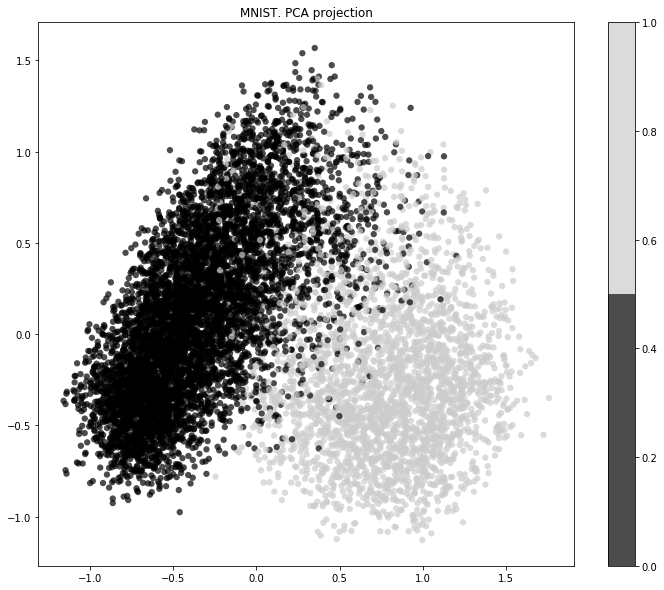

In [32]:
plt.figure(figsize=(12,10))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 2))
plt.colorbar()
plt.title('MNIST. PCA projection')

# Training model

In [33]:
import keras
from keras import regularizers
from keras.utils import np_utils

from IPython.display import clear_output
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn import decomposition
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

Using TensorFlow backend.


# Dense model

In [34]:

model_dnn = keras.models.Sequential()

model_dnn.add(keras.layers.Dense(512,
                             input_dim=hist_features.shape[1],
                             activation='relu', kernel_regularizer=regularizers.l2(0.0001) ) )
model_dnn.add(keras.layers.Dropout(0.5))
model_dnn.add(keras.layers.Dense(256,
                             activation='relu', kernel_regularizer=regularizers.l2(0.0001) ) )
model_dnn.add(keras.layers.Dropout(0.5))
model_dnn.add(keras.layers.Dense(2, activation='softmax'))
model_dnn.compile(optimizer='adam',              
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [35]:
model_dnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               11534848  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 514       
Total params: 11,666,690
Trainable params: 11,666,690
Non-trainable params: 0
_________________________________________________________________


In [57]:
x_train, x_val, y_train, y_val = train_test_split(
     hist_features, labels, test_size=0.2,
    random_state=42)
y_train_labels = np_utils.to_categorical(y_train)
y_val_labels = np_utils.to_categorical(y_val)

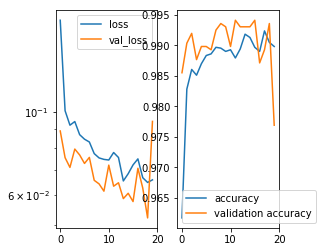

In [60]:
model_dnn.fit(x_train, y_train_labels, 
          batch_size=32, 
          validation_data=(x_val, y_val_labels),
          callbacks=[plot],
          verbose=0,
          epochs=20)

In [66]:
model_dnn.predict_classes(x_test1_hist_features)


array([1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1], dtype=int64)

In [67]:
model_dnn.predict_classes(x_test2_hist_features)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int64)

# Conv model

In [123]:

num_classes = 2
model_cnn = keras.models.Sequential()
model_cnn.add(keras.layers.Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=data.shape[1:]))
model_cnn.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(keras.layers.Dropout(0.25))
model_cnn.add(keras.layers.Flatten())
model_cnn.add(keras.layers.Dense(128, activation='relu'))
model_cnn.add(keras.layers.Dropout(0.5))
model_cnn.add(keras.layers.Dense(num_classes, activation='softmax'))

model_cnn.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                    metrics=['accuracy'])

In [117]:
model_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 62, 148, 32)       896       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 60, 146, 64)       18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 73, 64)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 30, 73, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 140160)            0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               17940608  
_________________________________________________________________
dropout_14 (Dropout)         (None, 128)               0         
__________

In [126]:
x_train, x_val, y_train, y_val = train_test_split(
     data, labels, test_size=0.2,
    random_state=42)
y_train_labels = np_utils.to_categorical(y_train)
y_val_labels = np_utils.to_categorical(y_val)

In [59]:
# updatable plot
# a minimal example (sort of)

class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        
        plt.show();
        
plot = PlotLearning()

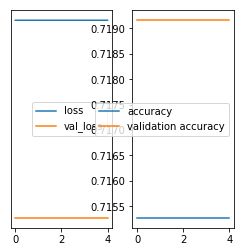

KeyboardInterrupt: 

In [122]:
model_cnn.fit(x_train, y_train_labels, 
          batch_size=32, 
          validation_data=(x_val, y_val_labels),
          callbacks=[plot],
          verbose=0,
          epochs=10)

<---------------------Too long trainging CNN on CPU.--------------------------->

# Testing model

In [42]:
def get_test_data(_dir):
    
    detector, predictor = load_dlib_detector("models/shape_predictor_68_face_landmarks.dat")

    aligner = FaceAligner(predictor=predictor)

    data = []
    labels = []

    for fname in tqdm.tqdm(os.listdir(_dir)):
        img = cv2.imread(os.path.join(_dir,fname))  
        # преобразуем изображение в чернобелый формат
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # detect faces in the grayscale image
        rect = face_detector_dlib(detector,gray)
        if rect is None:
            continue

        aligned_face = aligner.align(img, gray, rect)

        data.append(aligned_face)       

    return data

In [43]:
x_test1 = get_test_data(glasses_path)
x_test2 = get_test_data(no_glasses_path)

100%|████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.82it/s]


In [44]:
x_test1_hist_features = calculateHOG(x_test1)
x_test1_hist_features = np.squeeze(x_test1_hist_features)

x_test2_hist_features = calculateHOG(x_test2)
x_test2_hist_features = np.squeeze(x_test2_hist_features)

# x_test1_centered = x_test1_hist_features - x_test1_hist_features.mean(axis=0)
# x_test1_pca = pca_transformer.transform(x_test1_centered) 

# x_test2_centered = x_test2_hist_features - x_test2_hist_features.mean(axis=0)
# x_test2_pca = pca_transformer.transform(x_test2_centered) 

100%|███████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 525.85it/s]


In [45]:
# y_test1 = model.predict_classes(x_test1_pca)
# y_test2 = model.predict_classes(x_test2_pca)

In [46]:
# y_test1

In [85]:
# y_test2

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
      dtype=int64)

# SVM classifier

In [47]:
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

In [48]:
# train a Linear SVM on the data
model_svm = LinearSVC(C=100.0, random_state=42)
model_svm.fit(hist_features, labels)

LinearSVC(C=100.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0)

In [49]:
model_svm.predict(x_test1_hist_features)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [50]:
model_svm.predict(x_test2_hist_features)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# Saving final classifier

In [74]:
import pickle

In [75]:
filename="svm_classifier.sav"
pickle.dump(model_svm, open(filename, 'wb'))

In [76]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))


In [77]:
loaded_model.predict(x_test1_hist_features)

array([1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1])